<a href="https://colab.research.google.com/github/MeenalSinha/embryo-score-predictor/blob/main/IVF_Embryo_Scoring_Assistant_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STEP 0: Setup Kaggle API (Run Once)

In [ ]:
!pip -q install kaggle

In [ ]:
# Upload kaggle.json (make sure you renamed it before uploading)
from google.colab import files
files.upload()   # <- Select kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meenalsinha","key":"400e8bc7388a3687590f582dc979bb42"}'}

In [ ]:
# Move it to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### STEP 1: Test Kaggle API

In [ ]:
# If this works, API is correctly configured
!kaggle datasets list -s embryo

ref                                                                title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
gauravduttakiit/embryo-classification-based-on-microscopic-images  Embryo classification based on microscopic images      54320806  2023-10-03 14:30:17.163000            780         29  0.8125           
alexandervc/scrnaseq-changing-mouse-embryo-transcriptome           scRNA-seq changing mouse embryo transcriptome        1057148654  2021-10-04 13:04:02.563000             39          5  0.625            
alexandervc/rds-scrnaseq-data                                      scRNA-seq mouse embryonic stem cells                   70317236  2021-06-29 21:55:21.280000             76          7

### STEP 2: Download & Unzip Datasets

In [ ]:
# Embryo Classification Dataset
!kaggle datasets download -d gauravduttakiit/embryo-classification-based-on-microscopic-images
!unzip -q embryo-classification-based-on-microscopic-images.zip -d /content/datasets/embryo

# Human Blastocyst Dataset
!kaggle datasets download -d iamshahzaibkhan/human-blastocyst-dataset-for-ivf
!unzip -q human-blastocyst-dataset-for-ivf.zip -d /content/datasets/blastocyst

# Malaria Cell Images Dataset (proxy)
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip -d /content/datasets/malaria

# Blood Cell Images Dataset (proxy)
!kaggle datasets download -d paultimothymooney/blood-cells
!unzip -q blood-cells.zip -d /content/datasets/blood_cells

Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/embryo-classification-based-on-microscopic-images
License(s): CC0-1.0
  0% 0.00/51.8M [00:00<?, ?B/s]
100% 51.8M/51.8M [00:00<00:00, 1.15GB/s]
checkdir:  cannot create extraction directory: /content/datasets/embryo
           No such file or directory
Dataset URL: https://www.kaggle.com/datasets/iamshahzaibkhan/human-blastocyst-dataset-for-ivf
License(s): unknown
 96% 573M/596M [00:06<00:00, 37.8MB/s]
100% 596M/596M [00:06<00:00, 91.2MB/s]
checkdir:  cannot create extraction directory: /content/datasets/blastocyst
           No such file or directory
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 96% 651M/675M [00:01<00:00, 259MB/s]
100% 675M/675M [00:02<00:00, 337MB/s]
checkdir:  cannot create extraction directory: /content/datasets/malaria
           No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
License(s): o

In [ ]:
!mkdir -p /content/datasets

!unzip -q "embryo-classification-based-on-microscopic-images.zip" -d /content/datasets/embryo
!unzip -q "human-blastocyst-dataset-for-ivf.zip" -d /content/datasets/blastocyst
!unzip -q "cell-images-for-detecting-malaria.zip" -d /content/datasets/malaria
!unzip -q "blood-cells.zip" -d /content/datasets/blood_cells

### STEP 3: Explore Dataset

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Path to embryo dataset (can change between train/test)
dataset_path = "/content/datasets/embryo/train"

In [ ]:
# Print folder structure
for root, dirs, files in os.walk(dataset_path):
    print(root, len(files))

/content/datasets/embryo/train 0
/content/datasets/embryo/train/1 99
/content/datasets/embryo/train/0 573


In [ ]:
# Show some sample images
def show_samples(dataset_path, n_images=5):
    if not os.path.exists(dataset_path):
        print("❌ Path not found:", dataset_path)
        return

    classes = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]
    print("Classes found:", classes)

    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = os.listdir(cls_path)[:n_images]

        plt.figure(figsize=(12, 3))
        for i, img in enumerate(images):
            img_path = os.path.join(cls_path, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n_images, i + 1)
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"Class {cls}")
        plt.show()

Classes found: ['1', '0']


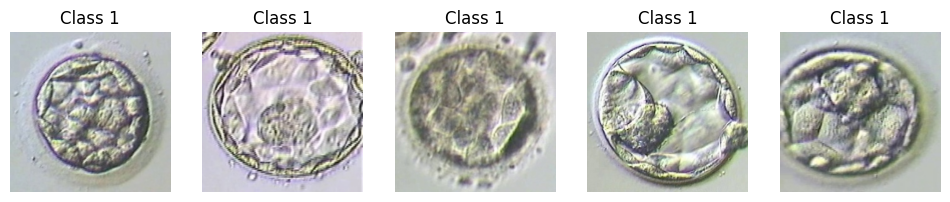

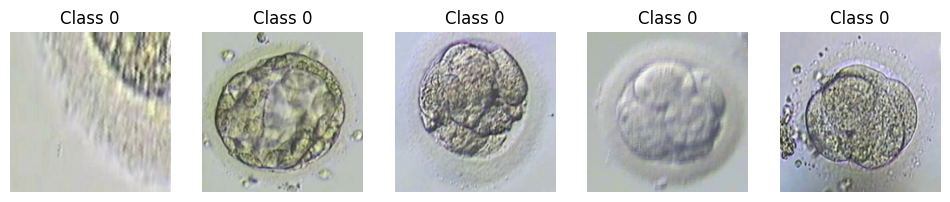

In [ ]:
# Example usage
show_samples("/content/datasets/embryo/train", n_images=5)

### STEP 4: Preprocessing & Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Target image size for CNN
img_size = (224, 224)

In [ ]:
# Training & validation generator
train_datagen = ImageDataGenerator(
    rescale=1./255,         # normalize pixel values
    validation_split=0.2,   # split train into train/val
    rotation_range=20,      # data augmentation
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    "/content/datasets/embryo/train",
    target_size=img_size,
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    "/content/datasets/embryo/train",
    target_size=img_size,
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 539 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [ ]:
# Test generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    "/content/datasets/embryo/test",
    target_size=img_size,
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 168 images belonging to 2 classes.


### STEP 5: Build CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Define CNN architecture
model = models.Sequential([
    layers.Input(shape=(224,224,3)),   # define input only once
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # binary classification
])

In [ ]:
# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Summary of model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### STEP 6: Train Model

In [ ]:
# Count samples in train set for each class
import numpy as np
from collections import Counter

In [ ]:
# train_gen has class indices in train_gen.classes
class_counts = Counter(train_gen.classes)
print("Class distribution in training data:", class_counts)

Class distribution in training data: Counter({np.int32(0): 459, np.int32(1): 80})


In [ ]:
# Compute class weights (inverse frequency)
total = sum(class_counts.values())
class_weight = {cls: total/(len(class_counts)*count) for cls, count in class_counts.items()}
print("Using class weights:", class_weight)

Using class weights: {np.int32(0): 0.5871459694989106, np.int32(1): 3.36875}


In [ ]:
# Train the model with class weights
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,   # increase to let model learn better
    class_weight=class_weight
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.4985 - loss: 1.3700 - val_accuracy: 0.8571 - val_loss: 0.6280
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.6583 - loss: 0.6751 - val_accuracy: 0.8271 - val_loss: 0.6514
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.7614 - loss: 0.6356 - val_accuracy: 0.4887 - val_loss: 0.6834
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.6886 - loss: 0.5448 - val_accuracy: 0.7970 - val_loss: 0.4681
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.7769 - loss: 0.5821 - val_accuracy: 0.8647 - val_loss: 0.3914
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.8086 - loss: 0.6279 - val_accuracy: 0.8346 - val_loss: 0.3667
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.7366 - loss: 0.5591 - val_accuracy: 0.8797 - val_loss: 0.3777
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.8334 - loss: 0.5374 - val_accuracy: 0.8571 - val_loss:

In [ ]:
# ✅ Save in .h5 format
model.save("ivf_embryo_model.h5")
print("Model saved as ivf_embryo_model.h5")

Model saved as ivf_embryo_model.h5


### STEP 7: Evaluate Model

In [ ]:
# Evaluate on test set
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.2f}")
print(f"✅ Test Loss: {loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 702ms/step - accuracy: 0.8914 - loss: 0.3530
✅ Test Accuracy: 0.83
✅ Test Loss: 0.4733


In [ ]:
# Plot training history (accuracy & loss)
import matplotlib.pyplot as plt

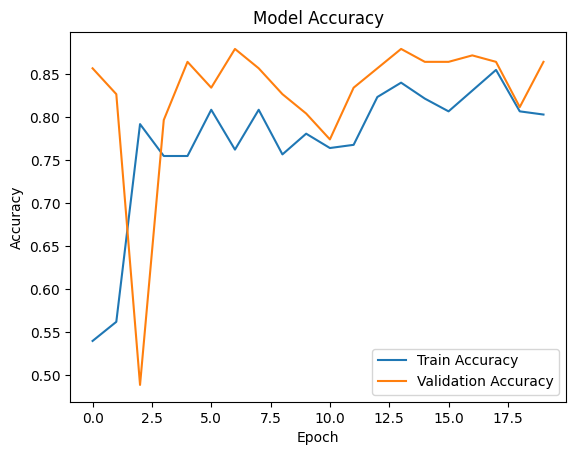

In [ ]:
# Accuracy curve
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

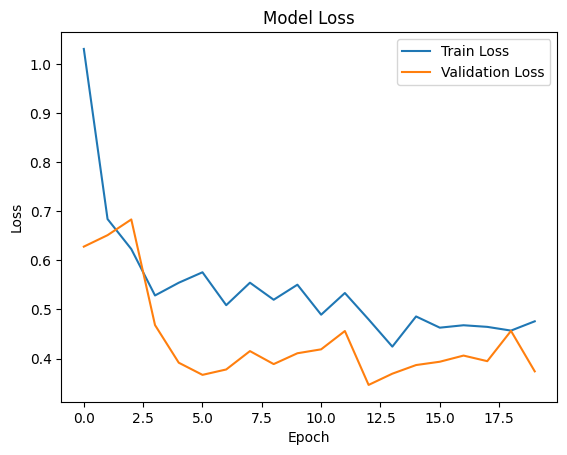

In [ ]:
# Loss curve
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### STEP 8: Save Model

In [ ]:
# Save the trained model
model.save("ivf_embryo_model.h5")
print("✅ Model saved as ivf_embryo_model.h5")

✅ Model saved as ivf_embryo_model.h5


In [ ]:
# (Optional) Download to your computer
from google.colab import files
files.download("ivf_embryo_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### STEP 9: Grad-CAM Explainability

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [ ]:
# ---- 1. Define Functional architecture identical to training ----
def build_functional_model():
    inputs = layers.Input(shape=(224,224,3), name="input_image")
    x = layers.Conv2D(32, (3,3), activation='relu', name='conv2d')(inputs)
    x = layers.MaxPooling2D((2,2), name='max_pooling2d')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', name='conv2d_1')(x)
    x = layers.MaxPooling2D((2,2), name='max_pooling2d_1')(x)
    x = layers.Conv2D(128, (3,3), activation='relu', name='conv2d_2')(x)
    x = layers.MaxPooling2D((2,2), name='max_pooling2d_2')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(128, activation='relu', name='dense')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='dense_1')(x)
    model = models.Model(inputs, outputs, name="ivf_functional_model")
    return model

In [ ]:
# ---- 2. Load model with weights ----
weights_file = "ivf_embryo_model.h5"
model = build_functional_model()
model.load_weights(weights_file)
print("✅ Functional model built & weights loaded")

✅ Functional model built & weights loaded


In [ ]:
# ---- 3. Get last Conv2D layer ----
last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
print("Using last conv layer:", last_conv_layer_name)

Using last conv layer: conv2d_2


In [ ]:
# ---- 4. Grad-CAM function ----
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap

In [ ]:
# ---- 5. Overlay function ----
def overlay_gradcam(img_path, model, last_conv_layer_name):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    # Preprocess
    img_resized = cv2.resize(img, (224,224))
    img_array = np.expand_dims(img_resized/255.0, axis=0)

    # Prediction
    pred = model.predict(img_array)[0][0]
    label = "Viable" if pred > 0.5 else "Non-viable"

    # Heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (W, H))
    heatmap = np.uint8(255 * heatmap)

    # Overlay
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, cv2.cvtColor(jet, cv2.COLOR_BGR2RGB), 0.4, 0)

    # Show results
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title(f"Original\n{label} ({pred:.2f})")
    plt.imshow(img); plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap="jet"); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(superimposed); plt.axis("off")
    plt.show()

File: /content/datasets/embryo/test/0/D3_001_cac975a1ed4b463a83098d4d6dcf4ac4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


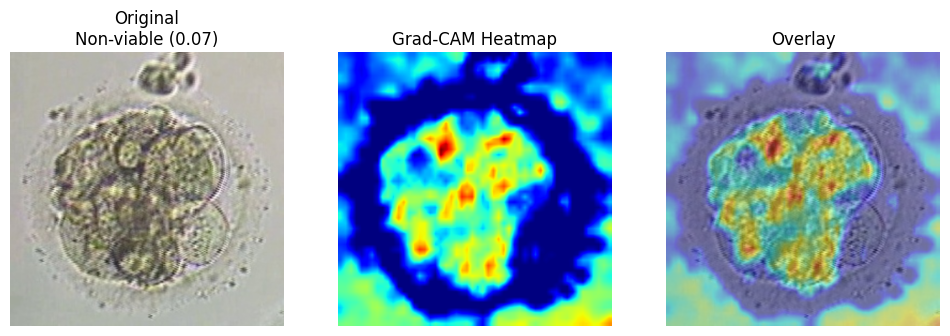

File: /content/datasets/embryo/test/0/D3_005_e293b3b710aa40b38b24cdd993686c20.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


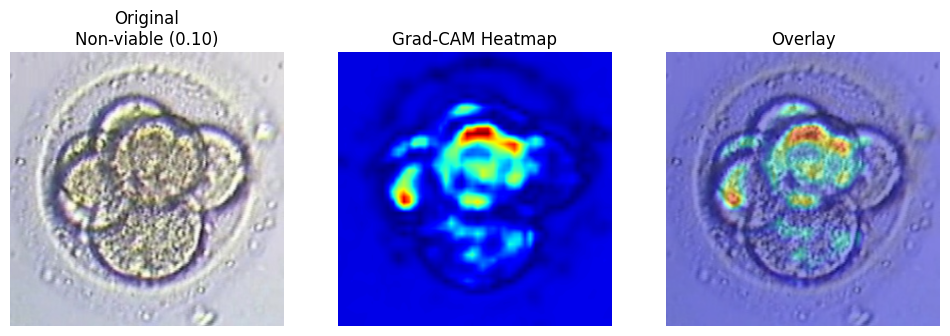

File: /content/datasets/embryo/test/0/D3_006_f9db57ee7fbc4bb886a9a16df92bc5b3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


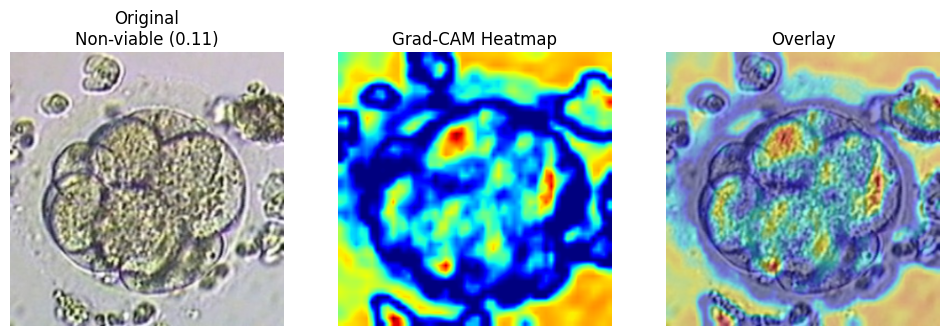

In [ ]:
# ---- 6. Run on some test images ----
for i in range(3):  # show 3 test samples
    print("File:", test_gen.filepaths[i])
    overlay_gradcam(test_gen.filepaths[i], model, last_conv_layer_name)

### STEP 10: Predict & Visualize Results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# 1️⃣ Predict on test set
y_pred_probs = model.predict(test_gen)   # probabilities
y_pred = (y_pred_probs > 0.5).astype("int32")  # convert to binary labels

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 716ms/step


In [ ]:
# 2️⃣ True labels
y_true = test_gen.classes

In [ ]:
# 3️⃣ Class labels
class_labels = list(test_gen.class_indices.keys())
print("Class labels:", class_labels)

Class labels: ['0', '1']


In [ ]:
# 4️⃣ Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       143
           1       0.45      0.60      0.52        25

    accuracy                           0.83       168
   macro avg       0.69      0.74      0.71       168
weighted avg       0.86      0.83      0.84       168



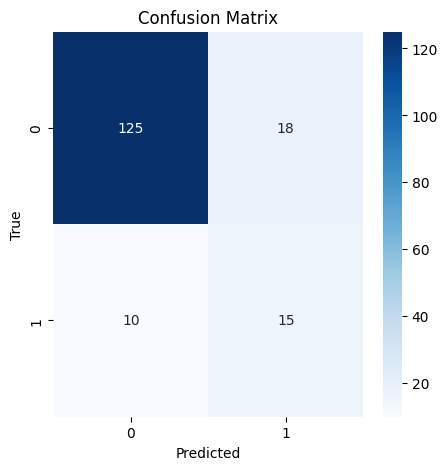

In [ ]:
# 5️⃣ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

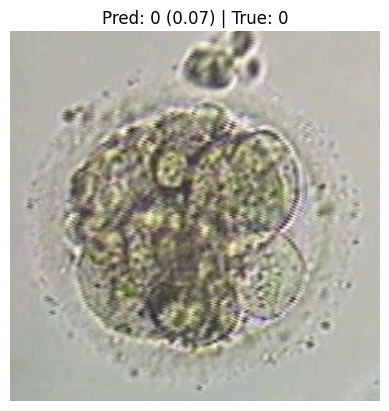

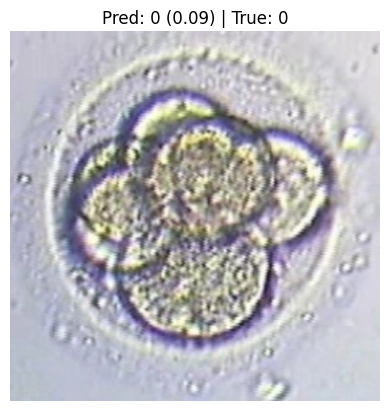

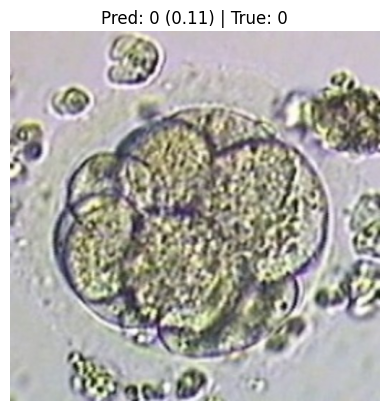

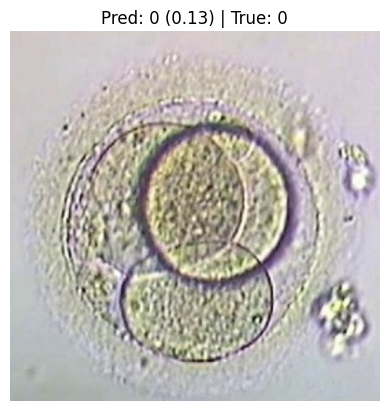

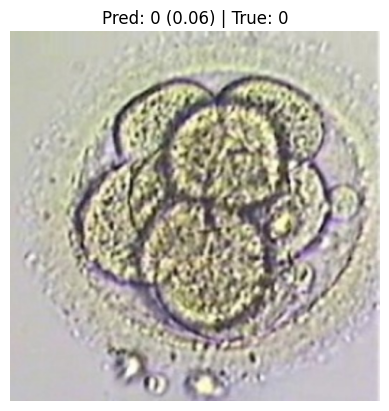

In [ ]:
# 6️⃣ Show a few sample predictions
for i in range(5):   # first 5 test images
    img_path = test_gen.filepaths[i]
    img = plt.imread(img_path)

    plt.imshow(img)
    plt.axis("off")

    prob = y_pred_probs[i][0]
    pred_class = class_labels[y_pred[i][0]]
    true_class = class_labels[y_true[i]]

    plt.title(f"Pred: {pred_class} ({prob:.2f}) | True: {true_class}")
    plt.show()

### Step 11: Threshold Tuning Code

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# --- Get predicted probabilities instead of class labels ---
y_probs = model.predict(test_gen)   # probabilities
y_true = test_gen.classes           # true labels

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 913ms/step


In [ ]:
# Try a new threshold (default is 0.5)
threshold = 0.4
y_pred = (y_probs >= threshold).astype(int)

In [ ]:
# --- Classification report ---
print("Classification Report (Threshold =", threshold, ")")
print(classification_report(y_true, y_pred))

Classification Report (Threshold = 0.4 )
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       143
           1       0.41      0.64      0.50        25

    accuracy                           0.81       168
   macro avg       0.67      0.74      0.69       168
weighted avg       0.85      0.81      0.83       168



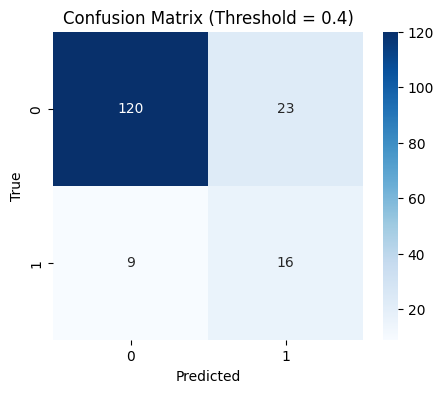

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

### Step 12: Precision–Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [ ]:
# --- Get predicted probabilities ---
y_probs = model.predict(test_gen)   # predicted probabilities
y_true = test_gen.classes           # true labels

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 732ms/step


In [ ]:
# --- Compute precision-recall pairs for different thresholds ---
precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

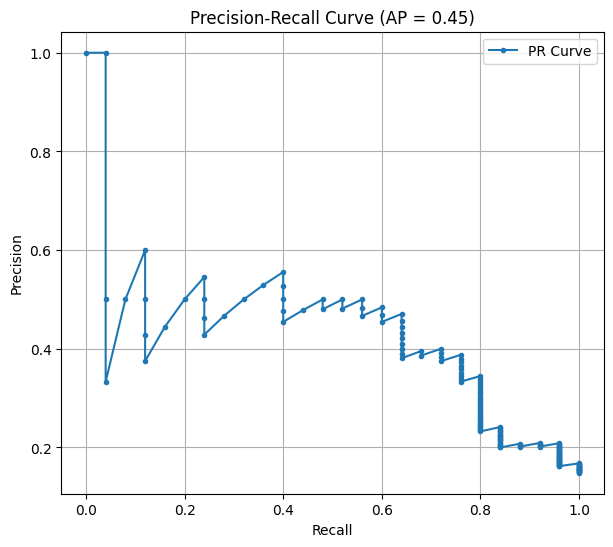

In [ ]:
# --- Plot Precision-Recall curve ---
plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, marker='.', label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {avg_precision:.2f})")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Show some threshold checkpoints ---
for t, p, r in zip(thresholds[::10], precisions[::10], recalls[::10]):  # step by 10 for readability
    print(f"Threshold={t:.2f} | Precision={p:.2f} | Recall={r:.2f}")

Threshold=0.02 | Precision=0.15 | Recall=1.00
Threshold=0.06 | Precision=0.16 | Recall=1.00
Threshold=0.07 | Precision=0.16 | Recall=0.96
Threshold=0.09 | Precision=0.17 | Recall=0.96
Threshold=0.11 | Precision=0.19 | Recall=0.96
Threshold=0.13 | Precision=0.20 | Recall=0.96
Threshold=0.15 | Precision=0.20 | Recall=0.88
Threshold=0.18 | Precision=0.21 | Recall=0.84
Threshold=0.19 | Precision=0.24 | Recall=0.84
Threshold=0.22 | Precision=0.26 | Recall=0.80
Threshold=0.25 | Precision=0.29 | Recall=0.80
Threshold=0.30 | Precision=0.34 | Recall=0.80
Threshold=0.35 | Precision=0.38 | Recall=0.72
Threshold=0.44 | Precision=0.42 | Recall=0.64
Threshold=0.68 | Precision=0.50 | Recall=0.56
Threshold=0.86 | Precision=0.56 | Recall=0.40
Threshold=0.94 | Precision=0.38 | Recall=0.12


In [ ]:
from sklearn.metrics import f1_score

best_f1, best_thresh = 0, 0
for t in np.linspace(0,1,100):
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"Best Threshold = {best_thresh:.2f}, F1 = {best_f1:.2f}")

Best Threshold = 0.48, F1 = 0.54


### Step 13: Custom Threshold Prediction Function

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
def predict_with_threshold(img_path, model, threshold=0.5):
    """
    Predict viability of embryo with custom threshold.

    Args:
        img_path (str): path to image
        model: trained keras model
        threshold (float): classification threshold

    Returns:
        prediction_label (str), probability (float)
    """
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224,224))
    img_array = np.expand_dims(img_resized/255.0, axis=0)

    # Get probability
    prob = model.predict(img_array)[0][0]

    # Apply threshold
    pred_class = 1 if prob >= threshold else 0
    label = "Viable" if pred_class == 1 else "Non-viable"

    # Show image with prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {label} | Prob={prob:.2f} | Thr={threshold}")
    plt.show()

    return label, prob

In [ ]:
# Pick a test image
sample_img = test_gen.filepaths[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


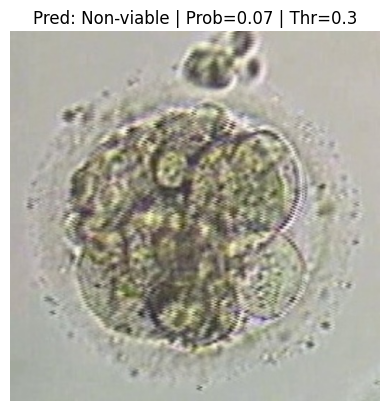

Threshold=0.3 → Non-viable (Prob=0.07)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


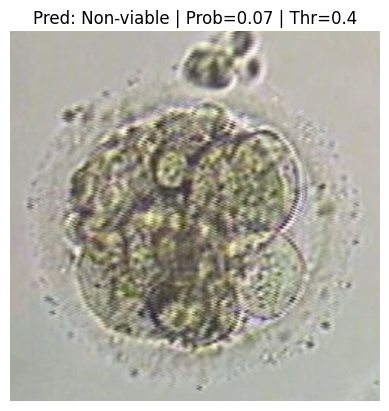

Threshold=0.4 → Non-viable (Prob=0.07)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


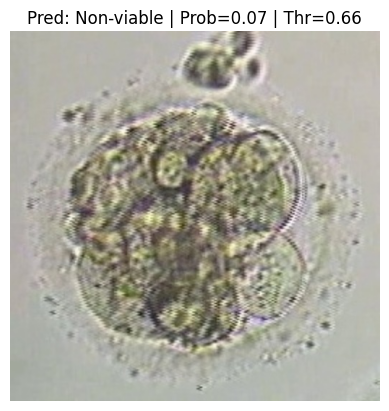

Threshold=0.66 → Non-viable (Prob=0.07)


In [ ]:
# Try different thresholds
for thr in [0.3, 0.4, 0.66]:
    label, prob = predict_with_threshold(sample_img, model, threshold=thr)
    print(f"Threshold={thr} → {label} (Prob={prob:.2f})")

### Step 14: Streamlit Deployment

In [ ]:
# 1. Install required packages
!pip install streamlit pyngrok reportlab --quiet
!pip install fpdf --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# 2. Write full app code into app.py
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2
from fpdf import FPDF

# --------------------------
# Load IVF Model + Grad-CAM
# --------------------------
MODEL_PATH = "ivf_embryo_model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Detect model input shape
if hasattr(model, "input_shape") and model.input_shape is not None:
    _, H, W, C = model.input_shape
    input_shape = (H or 224, W or 224, C or 3)
else:
    input_shape = (224, 224, 3)

# Warm up model (build input/output tensors)
dummy = np.zeros((1, *input_shape), dtype=np.float32)
_ = model.predict(dummy)

# Auto-detect last Conv layer
last_conv_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or "conv" in layer.name.lower():
        last_conv_name = layer.name
        break
if not last_conv_name:
    raise RuntimeError("No Conv2D layer found in model.")

# Grad-CAM heatmap generator
def make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_name, eps=1e-8):
    try:
        grad_model = tf.keras.models.Model(
            inputs=model.input,
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )
    except Exception:
        x = tf.keras.Input(shape=input_shape)
        y = x
        conv_output = None
        for layer in model.layers:
            y = layer(y)
            if layer.name == last_conv_layer_name:
                conv_output = y
        grad_model = tf.keras.models.Model(inputs=x, outputs=[conv_output, y])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if predictions.shape[-1] == 1:
            loss = predictions[:, 0]
        else:
            loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + eps)
    return heatmap

# --------------------------
# Preprocess helper
# --------------------------
def preprocess_image(uploaded_file):
    img = Image.open(uploaded_file).convert("RGB")
    img = img.resize((input_shape[0], input_shape[1]))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img, img_array

# --------------------------
# PDF Export helper (with colored table)
# --------------------------
def export_pdf(results_df, filename="results.pdf"):
    pdf = FPDF("P", "mm", "A4")
    pdf.add_page()
    pdf.set_font("Arial", size=14, style="B")
    pdf.cell(200, 10, "Embryo Quality Assessment Results", ln=True, align="C")
    pdf.ln(10)

    # Page width (usable area)
    page_width = pdf.w - 2 * pdf.l_margin

    # Define column widths dynamically (equal share for all columns)
    col_width = page_width / len(results_df.columns)

    # Table header
    pdf.set_font("Arial", size=12, style="B")
    headers = ["Embryo", "AI Prediction", "Label", "Expansion", "ICM", "TE", "Morph Score"]

    for header in headers:
        pdf.cell(col_width, 10, header, border=1, align="C")
    pdf.ln()

    # Table rows
    pdf.set_font("Arial", size=11)
    for _, row in results_df.iterrows():
        pdf.cell(col_width, 10, str(row["Embryo"]), border=1, align="C")
        pdf.cell(col_width, 10, f"{row['AI Prediction']:.2f}", border=1, align="C")

        # Color label cell
        if "High" in row["Label"]:
            pdf.set_text_color(0, 128, 0)  # Green
            label_text = "High Quality"
        else:
            pdf.set_text_color(220, 20, 60)  # Red
            label_text = "Low Quality"

        pdf.cell(col_width, 10, label_text, border=1, align="C")

        # Reset text color
        pdf.set_text_color(0, 0, 0)

        # Remaining cells
        pdf.cell(col_width, 10, str(row["Expansion"]), border=1, align="C")
        pdf.cell(col_width, 10, str(row["ICM"]), border=1, align="C")
        pdf.cell(col_width, 10, str(row["TE"]), border=1, align="C")
        pdf.cell(col_width, 10, str(row["Morph Score"]), border=1, align="C")
        pdf.ln()

    pdf.output(filename)

# --------------------------
# Streamlit UI
# --------------------------
st.set_page_config(page_title="Embryo Quality Assessment", layout="wide")

# Header banner
st.markdown("""
    <div style="background: linear-gradient(90deg, #1E90FF 0%, #6a11cb 50%, #ff7e5f 100%);
                padding: 25px; border-radius: 15px; text-align: center; margin-bottom:80px;">
        <h1 style="color: white; margin: 0; font-size: 36px;">🧠 Embryo Quality Assessment</h1>
        <p style="color: white; font-size:18px; margin-top:8px;">
            AI-Powered IVF Success Prediction
        </p>
    </div>
    """, unsafe_allow_html=True)

# Threshold section
st.markdown("""
    <h3 style="margin-bottom:0px;">⚙️ Set Prediction Threshold</h3>
""", unsafe_allow_html=True)

threshold = st.slider("", 0.0, 1.0, 0.5, 0.01, key="threshold_slider")

# Centered + larger font threshold value (emoji removed)
st.markdown(
    f"<h3 style='text-align:center; font-size:22px; margin-top:0px;'>Current Threshold = {threshold:.2f}</h3>",
    unsafe_allow_html=True
)

# Add spacing after threshold
st.markdown("<div style='margin-top:40px;'></div>", unsafe_allow_html=True)

# File uploader
uploaded_files = st.file_uploader("📤 Upload Embryo Images (Day 3–5)",
                                  type=["jpg", "jpeg", "png"], accept_multiple_files=True)

results = []

if uploaded_files:
    for idx, uploaded_file in enumerate(uploaded_files[:3]):  # limit 3
        st.subheader(f"Embryo {idx+1}")
        img, img_array = preprocess_image(uploaded_file)

        # Prediction
        pred_prob = float(model.predict(img_array)[0][0])
        pred_label = "High Quality" if pred_prob >= threshold else "Low Quality"

        # Grad-CAM
        heatmap = make_gradcam_heatmap(img_array, model)
        heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

        # Show side by side with reduced & centered images
        col1, col2 = st.columns(2)

        with col1:
            st.markdown("<div style='text-align:center;'>", unsafe_allow_html=True)
            st.image(img, caption="Original", width=350)
            st.markdown("</div>", unsafe_allow_html=True)

        with col2:
            st.markdown("<div style='text-align:center;'>", unsafe_allow_html=True)
            st.image(overlay, caption="Grad-CAM", width=350)
            st.markdown("</div>", unsafe_allow_html=True)

        # Morphological scoring
        st.markdown("**Morphological Scoring**")
        exp = st.selectbox(f"Expansion (Embryo {idx+1})", [1, 2, 3, 4, 5, 6])
        icm = st.selectbox(f"ICM (Embryo {idx+1})", ["A", "B", "C"])
        te = st.selectbox(f"TE (Embryo {idx+1})", ["A", "B", "C"])

        # Convert scores to numeric
        icm_map, te_map = {"A": 3, "B": 2, "C": 1}, {"A": 3, "B": 2, "C": 1}
        morph_score = exp + icm_map[icm] + te_map[te] + (pred_prob * 5)

        results.append({
            "Embryo": f"Embryo {idx+1}",
            "AI Prediction": pred_prob,
            "Label": f"<span style='color: {'green' if pred_label=='High Quality' else 'red'};'>{pred_label}</span>",
            "Expansion": exp,
            "ICM": icm,
            "TE": te,
            "Morph Score": round(morph_score, 2)
        })

# --------------------------
# Final summary
# --------------------------
if results:
    # Add spacing before summary
    st.markdown("<div style='margin-top:30px;'></div>", unsafe_allow_html=True)

    # Wrap the entire summary in a centered container
    st.markdown("<div style='display: flex; justify-content: center;'>", unsafe_allow_html=True)
    st.markdown("<div style='text-align: center; width: 80%;'>", unsafe_allow_html=True)

    # Heading
    st.markdown("""
        <h2 style="margin-bottom:20px;">
            📊 Final Results Summary
        </h2>
    """, unsafe_allow_html=True)

    # Results dataframe centered
    results_df = pd.DataFrame(results)

    st.markdown(
        results_df.to_html(index=False, escape=False, justify="center"),
        unsafe_allow_html=True
    )

    # Add extra spacing before buttons
    st.markdown("<div style='margin-top:50px;'>", unsafe_allow_html=True)

    # Export buttons centered
    col1, col2 = st.columns([0.5, 0.5], gap="large")
    with col1:
        csv = results_df.to_csv(index=False).encode("utf-8")
        st.download_button("⬇️ Download CSV", csv, "results.csv", "text/csv", use_container_width=True)
    with col2:
        pdf_path = "results.pdf"
        export_pdf(results_df, pdf_path)
        with open(pdf_path, "rb") as f:
            st.download_button("⬇️ Download PDF", f, "results.pdf", "application/pdf", use_container_width=True)

    st.markdown("</div></div>", unsafe_allow_html=True)

Overwriting app.py


In [ ]:
# 2. Import ngrok and authenticate
from pyngrok import ngrok

# 🔑 Paste your ngrok Authtoken (from https://dashboard.ngrok.com/get-started/your-authtoken)
!ngrok authtoken 32hiXcnJ8KdFMOUMhvfPGRufF1L_7xHSwZqS94vqcpC2bPQ1Q

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# 3. Expose Streamlit port (8501) to a public URL
public_url = ngrok.connect(8501)
print("🌍 Streamlit App URL:", public_url)

🌍 Streamlit App URL: NgrokTunnel: "https://c20f9f16ce24.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# 4. Run your Streamlit app (make sure `app.py` exists in Colab working dir)
!streamlit run app.py --server.port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.201.253.34:8501

2025-09-19 19:14:35.018757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758309275.047596   63270 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758309275.056811   63270 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758309275.078436   63270 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758309275.078494   63270 computation_placer.cc:177] computation placer al

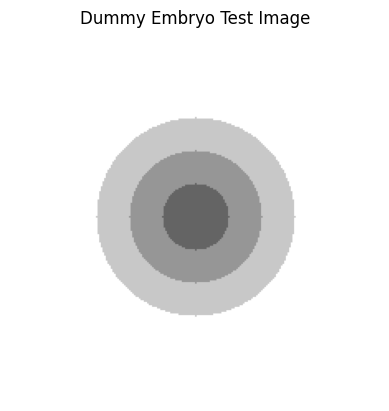

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create a blank white background
img = np.ones((224,224,3), dtype=np.uint8) * 255

# Draw a fake "embryo-like" circle
cv2.circle(img, (112,112), 60, (200,200,200), -1)  # grayish circle
cv2.circle(img, (112,112), 40, (150,150,150), -1)  # darker inside
cv2.circle(img, (112,112), 20, (100,100,100), -1)  # inner core

# Save image
cv2.imwrite("dummy_embryo.jpg", img)

# Show image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Dummy Embryo Test Image")
plt.show()